# Input Representation

## Introduction

In this project we improve handwriting. Initial representation of handwriting is usually done by recording the raw coordinates on the touch surface on which text is written. However, before actually using this data we need to think about how we want to represent it. This needs to be done to make sure representation is consistent over different devices, that the data is represented in a memmory efficient manner and such that the data can be used effectively. Therefore, in this notebook we will look at two different representations. The first is coordinates, but with normalisation and resampeling applied. The second is bezier curves that are fitted onto the data.

## Retrieving the data

The data we will be using as an example is stored in a csv file. In this case we will use the file to which the program AutoWrite writes it output.

In [1]:
path = "./../autowrite/data/last_input/strokes.npy"

Next we will retrieve this data using numpy which will will also use for the rest of our data manipulation.

In [2]:
import numpy as np

In [3]:
raw_strokes = np.load(path, allow_pickle=True)
print(raw_strokes.shape)
print(raw_strokes[0, 0])

(3, 179, 3)
[2.41000000e+02 2.44000000e+02 1.65496544e+12]


So in this case there are seven strokes with a maximum length of 99 data points. Each data point consists of an x- and y-coordinate and a timestamp.

We can plot what these strokes look like. These strokes are ragged arrays, so we only plot the coordinates that do not have a negative timestamp.

In [4]:
from matplotlib import pyplot as plt

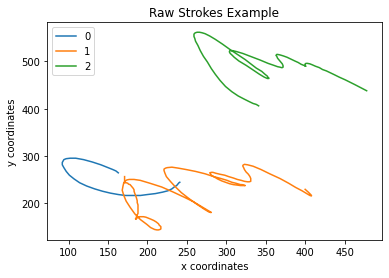

In [5]:
def plot_strokes(strokes, plot_name):
    plt.title(plot_name)
    plt.xlabel("x coordinates")
    plt.ylabel("y coordinates")

    for i, stroke in enumerate(strokes):
        plt.plot(stroke[:, 0][stroke[:, 2] >= 0], stroke[:, 1][stroke[:, 2] >= 0], label=str(i))

    plt.legend()
    plt.show()
    
plot_strokes(raw_strokes, "Raw Strokes Example")

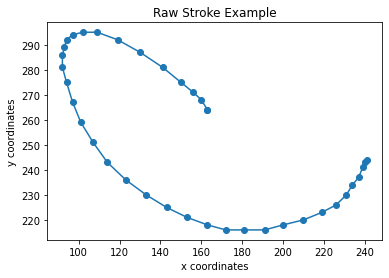

In [6]:
def plot_stroke(stroke, plot_name):
    plt.title(plot_name)
    plt.xlabel("x coordinates")
    plt.ylabel("y coordinates")

    plt.plot(stroke[:, 0][stroke[:, 2] >= 0], stroke[:, 1][stroke[:, 2] >= 0])
    plt.scatter(stroke[:, 0][stroke[:, 2] >= 0], stroke[:, 1][stroke[:, 2] >= 0])

    plt.show()
    
plot_stroke(raw_strokes[0], "Raw Stroke Example")

###### As you can see the y coordinates are flipped. So next we will normalize the input.

## Normalizing the data

First we will remove datapoints with the same (x,y) coordinates.

In [7]:
ustrokes = [np.unique(stroke[:, :2], return_index=True, axis=0)[1] for stroke in raw_strokes]
max_stroke_len = max(len(r) for r in ustrokes)

unique_strokes = np.zeros((len(ustrokes), max_stroke_len, 3))
unique_strokes[:, :, 2] -= 1

for i, row in enumerate(ustrokes):
    unique_strokes[i, :len(row)] = raw_strokes[i, np.sort(row)]

To normalize this data, we will first flip the y-axis, next we will move the starting coordinate to $(0, 0)$, after that we will scale the y and x axis linearly so the y values span a range $[0,1]$ and lastly we make the timestamps relative.

We can simply flip the strokes around by multiply the y-coordinates by $-1$.

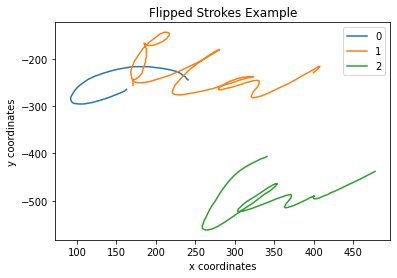

In [8]:
flipped_strokes = unique_strokes.copy()

non_ragged = unique_strokes[:, :, 2] >= 0

flipped_strokes[:, :, 1][non_ragged] *= -1
plot_strokes(flipped_strokes, "Flipped Strokes Example")

Next we move the initial x-value and y-value to $0$. We do this by subtracting the initial coordinates from all coordinates.

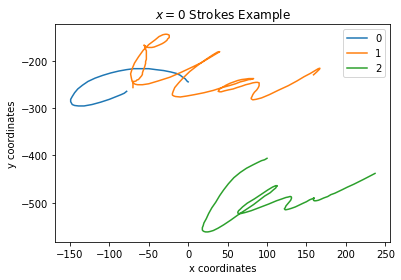

In [9]:
x0_strokes = flipped_strokes.copy()

x0_strokes[:, :, 0][non_ragged] -= x0_strokes[0, 0, 0]

plot_strokes(x0_strokes, "$x=0$ Strokes Example")

Now we scale both the x- and y-axis linearly so all y-values values in the range $[0,1]$. We do this by first moving the lowest y values to $y=0$ and then scaling the other values by the dividing them with the highest y value.

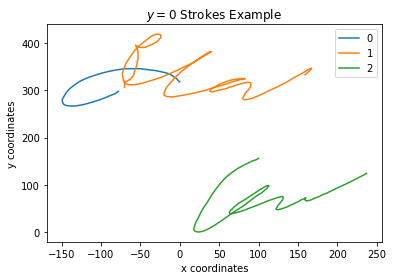

In [10]:
y0_strokes = x0_strokes.copy()

y0_strokes[:, :, 1][non_ragged] -= np.amin(y0_strokes[:, :, 1])

plot_strokes(y0_strokes, "$y=0$ Strokes Example")

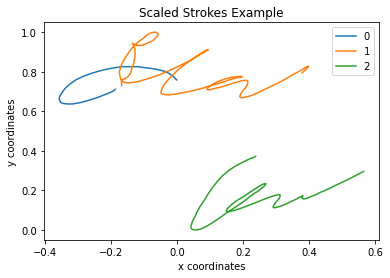

In [11]:
scaled_strokes = y0_strokes.copy()

scaled_strokes[:, :, :2][non_ragged] /= np.amax(scaled_strokes[:, :, 1])

plot_strokes(scaled_strokes, "Scaled Strokes Example")

In [12]:
relative_timestamp_strokes = scaled_strokes.copy()

relative_timestamp_strokes[:, :, 2][non_ragged] -= relative_timestamp_strokes[0, 0, 2]

With this we have finished normalizing the data. These operations can be put together for optimization, since they are executed some signs are turned around.

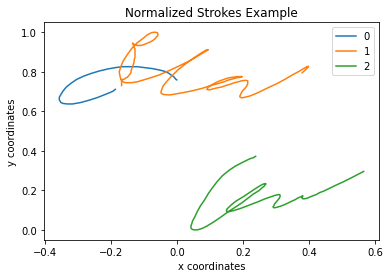

[[ 0.00000000e+00  7.58949881e-01  0.00000000e+00]
 [-2.38663484e-03  7.61336516e-01  8.00000000e+00]
 [-4.77326969e-03  7.66109785e-01  1.80000000e+01]
 [-9.54653938e-03  7.75656325e-01  2.30000000e+01]
 [-1.67064439e-02  7.82816229e-01  2.90000000e+01]
 [-2.38663484e-02  7.92362768e-01  3.80000000e+01]
 [-3.57995227e-02  8.01909308e-01  4.60000000e+01]
 [-5.25059666e-02  8.09069212e-01  5.40000000e+01]
 [-7.39856802e-02  8.16229117e-01  6.00000000e+01]
 [-9.78520286e-02  8.21002387e-01  6.70000000e+01]
 [-1.19331742e-01  8.25775656e-01  7.60000000e+01]
 [-1.43198091e-01  8.25775656e-01  8.40000000e+01]
 [-1.64677804e-01  8.25775656e-01  8.90000000e+01]
 [-1.86157518e-01  8.21002387e-01  9.80000000e+01]
 [-2.10023866e-01  8.13842482e-01  1.06000000e+02]
 [-2.33890215e-01  8.04295943e-01  1.14000000e+02]
 [-2.57756563e-01  7.92362768e-01  1.22000000e+02]
 [-2.81622912e-01  7.78042959e-01  1.28000000e+02]
 [-3.03102625e-01  7.61336516e-01  1.35000000e+02]
 [-3.19809069e-01  7.42243437e-

In [13]:
normalized_strokes = unique_strokes.copy()

normalized_strokes[non_ragged] -= [normalized_strokes[0, 0, 0], np.amax(normalized_strokes[:, :, 1]), normalized_strokes[0, 0, 2]]
normalized_strokes[non_ragged] /= [-np.amin(normalized_strokes[:, :, 1]), np.amin(normalized_strokes[:, :, 1]), 1]

plot_strokes(normalized_strokes, "Normalized Strokes Example")
print(normalized_strokes[0,:])

## Raw Touch Points

To use the raw touch point we will first resample each stroke and then make a single sequence, putting all arrays into one larger array, an extra parameter is then added for noting when a stroke starts, this parameter is set to 1 if the point is a starting point for a stroke, else it is $0$. An extra parameter is also added for indicating the pen direction in the stroke. This parameter is $0$ for pen down and $1$ for pen up.

In [20]:
def sampleLine(p0, p1, delta=0.05):
    l = ((p1[0]-p0[0])**2 + (p1[1]-p0[1])**2)**0.5
    num = int(l/delta)
    
    if num == 0:
        return [p0]
    
    sampled_xs = np.linspace(p0[0], p1[0], num)
    sampled_ys = np.linspace(p0[1], p1[1], num)
    sampled_timestamps = np.linspace(p0[2], p1[2], num)

    return np.stack((sampled_xs, sampled_ys, sampled_timestamps), axis=1).tolist()

def resampleStroke(stroke):
    resampled_stroke = []
    
    for i, _ in enumerate(stroke[stroke[:, 2] >= 0][:-1]):
        resampled_stroke.extend(sampleLine(stroke[i], stroke[i+1]))
        
    return resampled_stroke

rs = [resampleStroke(stroke) for stroke in normalized_strokes]

print(rs)

[[array([0.        , 0.75894988, 0.        ]), array([-2.38663484e-03,  7.61336516e-01,  8.00000000e+00]), array([-4.77326969e-03,  7.66109785e-01,  1.80000000e+01]), array([-9.54653938e-03,  7.75656325e-01,  2.30000000e+01]), array([-1.67064439e-02,  7.82816229e-01,  2.90000000e+01]), array([-2.38663484e-02,  7.92362768e-01,  3.80000000e+01]), array([-3.57995227e-02,  8.01909308e-01,  4.60000000e+01]), array([-5.25059666e-02,  8.09069212e-01,  5.40000000e+01]), array([-0.07398568,  0.81622912, 60.        ]), array([-0.09785203,  0.82100239, 67.        ]), array([-0.11933174,  0.82577566, 76.        ]), array([-0.14319809,  0.82577566, 84.        ]), array([-0.1646778 ,  0.82577566, 89.        ]), array([-0.18615752,  0.82100239, 98.        ]), array([ -0.21002387,   0.81384248, 106.        ]), array([ -0.23389021,   0.80429594, 114.        ]), array([ -0.25775656,   0.79236277, 122.        ]), array([ -0.28162291,   0.77804296, 128.        ]), array([ -0.30310263,   0.76133652, 135.  

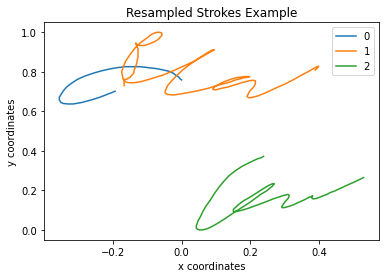

In [19]:
max_stroke_len = max(len(r) for r in rs)

resampled_strokes = np.zeros((len(rs), max_stroke_len, 3))
resampled_strokes[:, :, 2] -= 1

for i, row in enumerate(rs):
    resampled_strokes[i, :len(row)] = row
    
plot_strokes(resampled_strokes, "Resampled Strokes Example")

Lastly we will append all strokes to eachother to form one long sequence of datapoints. We now add values to show if a datapoint is a starting point for a stroke and whether the pen direction is up or down.

In [16]:
# Directions per stroke.
directions = np.apply_along_axis(lambda x: int(x[x >= 0][0] < x[x >= 0][-1]), 1, resampled_strokes[:,:,1])

# Reshape into the shape we want.
directions = np.tile(np.expand_dims(directions, axis=0).transpose(), (1, resampled_strokes.shape[1]))

rtps = np.append(resampled_strokes, np.expand_dims(directions, axis=2), axis=2)

In [17]:
rtps = np.append(rtps, np.zeros((resampled_strokes.shape[0], resampled_strokes.shape[1], 1)), axis=2)
rtps[:, 0, 4] = 1

In [18]:
touch_points = rtps[rtps[:, :, 2] >= 0].tolist()
touch_points = np.array(touch_points)
print(touch_points.shape)

(304, 5)


## Bezier Curves

### Scaling Timestamps

We can also represent the input as a number of fitted bezier curves.

To do this, first the timestamps are scaled linearly to match the length of the ink. Todo this we first calculate the total length of the ink using pythagoras.

In [22]:
squared_differences = np.diff(normalized_strokes, axis=1)[:, :, :2]**2
distances = np.sum(squared_differences, axis=2)**(1/2)

# Last difference is to 0, we do not want to count this
total_length = np.sum(distances[(normalized_strokes[:, :, 2] >= 0)[:, 1:]])
print(total_length)

6.559245836787186


All timestamps are scaled so the largest timestamp is equal to this value.

In [23]:
scaling_factor = normalized_strokes[non_ragged][-1, 2] / total_length
print(scaling_factor)

normalized_timestamps = normalized_strokes.copy()
normalized_timestamps[:,:,2][non_ragged] /= scaling_factor

print(normalized_timestamps[-1])

759.690995579569
[[ 1.15695067  0.61883408  6.23279732]
 [ 1.15695067  0.62331839  6.39470525]
 [ 1.16143498  0.62331839  6.4026032 ]
 [ 1.16591928  0.62780269  6.40918482]
 [ 1.1793722   0.6367713   6.42103175]
 [ 1.20179372  0.65022422  6.43156234]
 [ 1.23318386  0.67264574  6.44077662]
 [ 1.27802691  0.70403587  6.44999089]
 [ 1.33632287  0.73991031  6.46052149]
 [ 1.39013453  0.77578475  6.46973576]
 [ 1.44394619  0.80717489  6.48289901]
 [ 1.48878924  0.83408072  6.4881643 ]
 [ 1.52466368  0.85201794  6.50001123]
 [ 1.5470852   0.86547085  6.51054182]
 [ 1.56502242  0.87443946  6.5197561 ]
 [ 1.57399103  0.88340807  6.52765404]
 [ 1.58295964  0.88789238  6.53818464]
 [ 1.59192825  0.89237668  6.54871524]
 [ 1.58744395  0.89237668  6.55924584]
 [ 0.          0.         -1.        ]
 [ 0.          0.         -1.        ]
 [ 0.          0.         -1.        ]
 [ 0.          0.         -1.        ]
 [ 0.          0.         -1.        ]
 [ 0.          0.         -1.        ]
 [ 0.   

### Fitting The Curve

The bezier curves wich we want to use to represent our data can be described by cubic polynomials in range $[0,1]$. cite google paper

$x(s) = \alpha_0 + \alpha_1 s + \alpha_2 s^2 + \alpha_3 s^3$

$y(s) = \beta_0 + \beta_1 s + \beta_2 s^2 + \beta_3 s^3$

$t(s) = \gamma_0 + \gamma_1 s + \gamma_2 s^2 + \gamma_3 s^3$

This means that we need to estimate these 12 parameters. If we know at what points $s$ the closest points of a fit lie, then we can simply calculate these parameters using least squares.

Some explanation of least squares. We want to minimalize the sum of squared errors. Which is defined as follows:

$\Sigma_{i=0}^{N-1}\  (x_i - x(s_i))^2 + (y_i - y(s_i))^2 + (t_i - t(s_i))^2$

It is the sum the differences of the estimations of the datapoints and the datapoints themselves, squared.

How ever to make this fit we would have to first know what $s_i$ is. We don't so we will make a guess.

As an example lets generate some data, with a certain set of parameters and then try to derive those parameters form the data.

In [24]:
def makeSMatrix(s, width): 
    return np.column_stack([s**p for p in range(width)])

s = np.linspace(0, 1, 5)
S = makeSMatrix(s, 4) # s closest points estimation 

In [25]:
P = np.random.rand(4, 3) # parameters
print(P.shape, P)

(4, 3) [[0.49120446 0.9859881  0.51280821]
 [0.61839551 0.97041724 0.85899294]
 [0.94962411 0.98475974 0.96439102]
 [0.71890534 0.26301303 0.93146932]]


In [26]:
D = S@P # generate the data
print(D.shape)
D += np.random.rand(*D.shape) # add some randomness

(5, 3)


In [27]:
PE = np.linalg.lstsq(S, D, rcond=-1)[0] # estimate paremeters
print(PE.shape)

(4, 3)


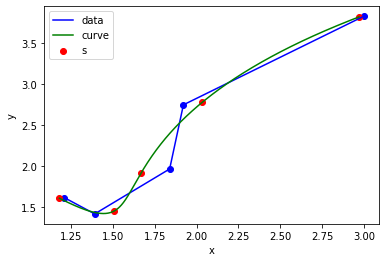

In [28]:
%matplotlib inline
    
def plot2D_curve_with_data(data, P, s):
    D = data[data[:, 2] >= 0]
    curve_points = makeSMatrix(s, 4)@P
    curve = makeSMatrix(np.linspace(s[0], s[-1], 1000), 4)@P
    
    plt.scatter(D[:, 0], D[:, 1], color="b")
    plt.plot(D[:, 0], D[:, 1], label="data", color="b")
    plt.plot(curve[:, 0], curve[:, 1], label="curve", color="g")
    plt.scatter(curve_points[:, 0], curve_points[:, 1], label="s", color="r")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()
    
plot2D_curve_with_data(D, PE, s)

It is clear initializing the vector equidistantly does not give the best estimation of s. Therefore, we will initialize the points based of relative the length to the datacurve (relative to the total length of the curve formed by the data points), and then try to improve our estimation of s. We can calculate the sum of squared errors to see this.

In [29]:
def SSE(data, P, s):
    D = data[data[:, 2] >= 0]
    S = makeSMatrix(s, 4)
    return np.sum(np.sum((D - (S@P))**2, axis=1), axis=0)

print(SSE(D, PE, s))

0.07912122325209492


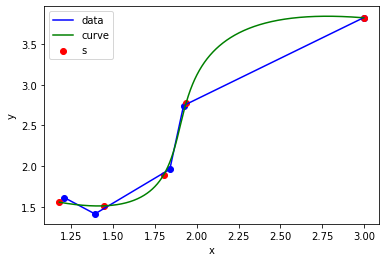

0.07293534065822874


In [30]:
diffs = (D[1:] - D[:-1])
distances = (diffs[:, 0]**2 + diffs[:, 1]**2)**(1/2)
distances = np.insert(distances, 0, 0)
cummulative_distances = np.cumsum(distances)
s2 = cummulative_distances/cummulative_distances[-1]

S2 = makeSMatrix(s2, 4)
PE2 = np.linalg.lstsq(S2, D, rcond=-1)[0]

plot2D_curve_with_data(D, PE2, s2)
print(SSE(D, PE2, s2))

This clearly already leads to a better fit. In addition to thies we can try improving this estimation of s. We do this by using a newton step on the following function:

$x'(s_i)(x_i − x(s_i)) + y'(s_i)(y_i − y(s_i)) = 0$.

This function is 0 when the direction of the derivative of the curve is orthogonal to the difference between the data point and the the datapoint estimation of the corresponding s. This would mean that this is indeed a good estimation of s, since that point the point on the curve that is closest to the datapoint we want to fit on.

Newton step is done by subracting the first derivative of this function divided by the second derivative of this function from $s_i$.

The first derivative is:
    
$(x_i - x(s_i))x''(s_i) + (y_i - y(s_i))y''(s_i) - x''(s_i)^2 - y''(s_i)^2$

This means the second derivative is:

$(x_i - x(s_i))x'''(s_i) + (y_i - y(s_i))y'''(s_i) - 2x'''(s_i)x''(s_i) - x'(s_i)x''(s_i) - 2y'''(s_i)y''(s_i) - y'(s_i)y''(s_i)$

In [31]:
def newton_step(data, P, s):
    D = data[data[:, 2] >= 0]
    S = makeSMatrix(s, 4)
    C = S@P

    P1d = P[1:, :] * [[1], [2], [3]]
    C1d = makeSMatrix(s, 3)@P1d # First derivates
    
    P2d = P1d[1:, :] * [[1], [2]]
    C2d = makeSMatrix(s, 2)@P2d # Second derivates
    
    P3d = P2d[1:, :]
    C3d = makeSMatrix(s, 1)@P3d # Third derivates
    
    N1 = (D[:, 0] - C[:, 0])*C2d[:, 0] + (D[:, 1] - C[:, 1])*C2d[:, 1]\
            - C2d[:, 0]**2 - C2d[:, 1]**2
    
    N2 = (D[:, 0] - C[:, 0])*C3d[:, 0] + (D[:, 1] - C[:, 1])*C3d[:, 1]\
            - 2*C3d[:, 0]*C2d[:, 0] - C1d[:, 0]*C2d[:, 0]\
            - 2*C3d[:, 1]*C2d[:, 1] - C1d[:, 1]*C2d[:, 1]
    
    s_new = np.copy(s)
    s_new[1:-1] -= (N1/N2)[1:-1] # Keep s=0 and s=1 in place.
    return s_new

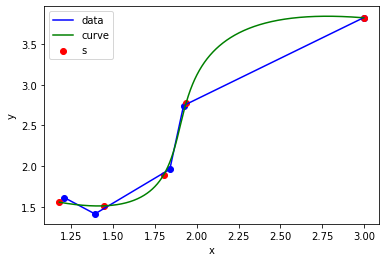

0.07293534065822874


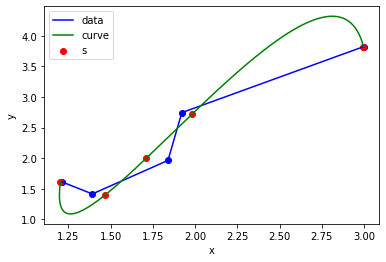

0.09465002115843764


In [32]:
s3 = newton_step(D, PE2, s2)
S3 = makeSMatrix(s3, 4)
PE3 = np.linalg.lstsq(S3, D, rcond=-1)[0]

plot2D_curve_with_data(D, PE2, s2)
print(SSE(D, PE2, s2))

plot2D_curve_with_data(D, PE3, s3)
print(SSE(D, PE3, s3))

As we can see the points s move as would like them to, such that the angle that is formed is 90 degrees. We can use this polynomial to compute the control points for the bezier curve as follows.

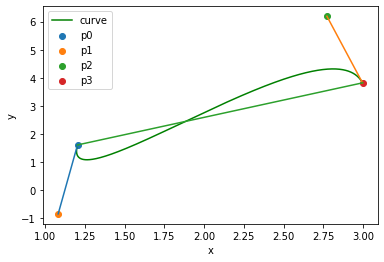

In [48]:
def get_control_points(P):
    C = makeSMatrix(np.array([0, 1]), 4)@P
    p0 = C[0, :2]
    p3 = C[-1, :2]

    PE31d = PE3[1:, :] * [[1], [2], [3]]
    C1d = makeSMatrix(np.array([0, 1]), 3)@PE31d # First derivates

    p1 = p0 + (1/3) * C1d[0, :2]
    p2 = p3 - (1/3) * C1d[-1, :2]

    return [p0, p1, p2, p3]
    
    
p0, p1, p2, p3 = get_control_points(PE3) # Get associated controlpoints.
curve = makeSMatrix(np.linspace(0, 1, 1000), 4)@PE3

plt.plot(curve[:, 0], curve[:, 1], label="curve", color="g")

plt.scatter(p0[0], p0[1], label="p0")
plt.scatter(p1[0], p1[1], label="p1")
plt.plot([p0[0], p1[0]], [p0[1], p1[1]])

plt.scatter(p2[0], p2[1], label="p2")
plt.scatter(p3[0], p3[1], label="p3")
plt.plot([p2[0], p3[0]], [p2[1], p3[1]])

plt.plot([p0[0], p3[0]], [p0[1], p3[1]])

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

We can use this to form the final shape we will feed into the network.

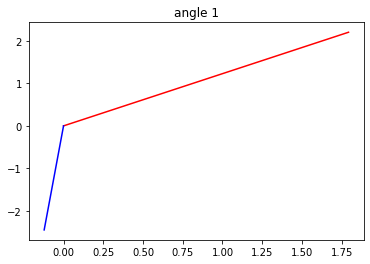

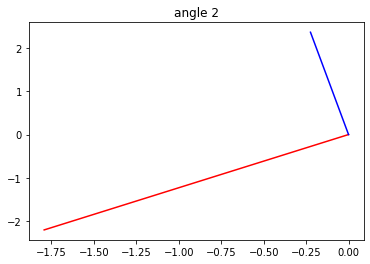

deg a1 143.76175079705774 2.5091158898402397
deg a2 135.51086004474368 2.3651106799900075


In [49]:
def parameterize_curve(P, p, debug=False):
    p0, p1, p2, p3 = get_control_points(P)
    
    vec_14 = p3 - p0 # Vec from controlpoint 1 to control point 4
    vec_41 = p0 - p3 # Vec from controlpoint 4 to control point 1
    
    distance_endpoints = np.sum((p3 - p0)**2)**(1/2)

    control_vec1 = p1 - p0
    control_vec2 = p2 - p3

    d1 = np.sum(control_vec1**2)**(1/2) / distance_endpoints
    d2 = np.sum(control_vec2**2)**(1/2) / distance_endpoints
    
    a1 = np.arctan2(
        control_vec1[0] * vec_14[1] - control_vec1[1] * vec_14[0],
        np.dot(vec_14, control_vec1)
    )
    
    a2 = np.arctan2(
        control_vec2[0] * vec_41[1] - control_vec2[1] * vec_41[0],
        np.dot(vec_41, control_vec2)
    )

    if debug:
        plt.title("angle 1")
        plt.plot([0, vec_14[0]], [0, vec_14[1]], color="r")
        plt.plot([0, control_vec1[0]], [0, control_vec1[1]], color="b")
        plt.show()
    
        plt.title("angle 2")
        plt.plot([0, vec_41[0]], [0, vec_41[1]], color="r")
        plt.plot([0, control_vec2[0]], [0, control_vec2[1]], color="b")
        plt.show()

    return [vec_14[0], vec_14[1], d1, d2, a1, a2, P[1, 2], P[2, 2], P[3, 2], p]

res = parameterize_curve(PE3, 1, debug=True)

print("deg a1", (res[4] * 180) / np.pi, res[4])
print("deg a2", (res[5] * 180) / np.pi, res[5])

We can combine this into a function that fits a curve to the given stroke and returns an estimation for the closest points and the estimated parameters. 

In [35]:
def get_relative_distances(data):
    diffs = (data[1:, :] - data[:-1, :])
    distances = np.insert((diffs[:, 0]**2 + diffs[:, 1]**2)**(1/2), 0, 0)
    cummulative_distances = np.cumsum(distances)
    print(cummulative_distances)
    return cummulative_distances/cummulative_distances[-1]

(105, 3)
[0.         0.0044843  0.00896861 0.01345291 0.01979468 0.02876329
 0.03324759 0.04327481 0.05224341 0.06227063 0.07229784 0.08232505
 0.09235226 0.10503579 0.11771932 0.13040285 0.14657124 0.16273963
 0.17890802 0.19896244 0.22138397 0.24143839 0.25992765 0.28407637
 0.30256564 0.32543119 0.34336841 0.36130563 0.37924285 0.39342347
 0.41191273 0.42609335 0.43877688 0.45494527 0.4676288  0.47765601
 0.48768322 0.49771043 0.50667904 0.51564765 0.52567486 0.53570207
 0.5483856  0.564554   0.57873461 0.59878903 0.6172783  0.64563953
 0.67828576 0.71443939 0.75059301 0.78674663 0.81845545 0.83639267
 0.85432989 0.86778281 0.88572003 0.90814155 0.93056308 0.95746891
 0.97989043 1.00716739 1.03003295 1.05289851 1.07138777 1.08987704
 1.1083663  1.12254692 1.13257413 1.14874252 1.15876973 1.16879694
 1.17328125 1.18330846 1.18965022 1.19413453 1.19861883 1.2049606
 1.2094449  1.22362552 1.24211478 1.27047602 1.31620713 1.36733607
 1.42189    1.47301894 1.51983646 1.56117971 1.6012885

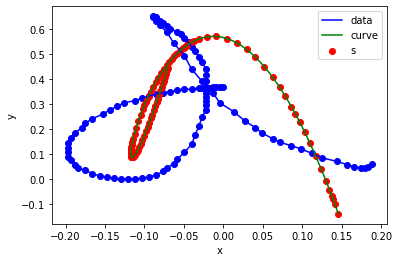

[0.         0.22474586 0.2260394  0.22733196 0.22918018 0.23175962
 0.23304789 0.23594748 0.23851688 0.2414075  0.24429346 0.24717479
 0.25005154 0.25369938 0.25734005 0.26097365 0.26558414 0.27020366
 0.27481225 0.28051859 0.28687105 0.29254399 0.29776516 0.30456307
 0.30975614 0.31616291 0.32117576 0.32617863 0.331172   0.33510519
 0.34022851 0.34414932 0.34763128 0.35207713 0.35555048 0.35827867
 0.36100478 0.36372892 0.3661426  0.36855492 0.37122937 0.37390252
 0.37726901 0.38155237 0.3853056  0.39061682 0.39551703 0.40304932
 0.41176327 0.42152354 0.43150224 0.44197066 0.45223327 0.45936278
 0.46977625 0.48729932 0.35838639 0.45347928 0.46633053 0.47620346
 0.48319358 0.49109855 0.49747841 0.50373363 0.50873255 0.51369648
 0.51863564 0.52241142 0.52507726 0.52937248 0.53203213 0.5346903
 0.53587902 0.5385357  0.54021954 0.54140751 0.54259538 0.54427912
 0.54551211 0.54941297 0.55450084 0.56231005 0.57492825 0.58908468
 0.6042662  0.61857525 0.63175572 0.64346601 0.65487971 0.66585

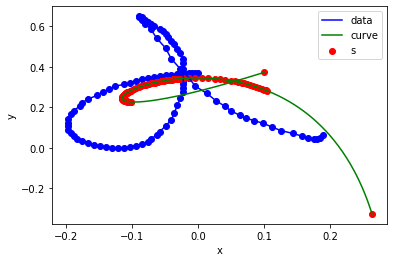

[ 0.          0.35194832  0.35280137  0.35365579  0.3548784   0.3565951
  0.35745574  0.35940564  0.36113864  0.36310318  0.36507588  0.36705723
  0.36904776  0.37157173  0.3741107   0.37666584  0.3799598   0.38325398
  0.38658034  0.39073294  0.39548383  0.39977283  0.40374518  0.40908241
  0.41322925  0.41846856  0.42263316  0.42690594  0.43130151  0.43479604
  0.43951978  0.44324861  0.44660104  0.45107455  0.45469258  0.45762734
  0.46066127  0.46380467  0.46673076  0.46977019  0.47338902  0.47719681
  0.48242745  0.4898147   0.49713503  0.50888536  0.52193923  0.54775376
  0.59355974  0.69697989  1.09785175 -0.77674118  0.12024138  0.2319052
  0.30706697  0.36678579  0.4593523   0.16960191  0.29337355  0.33724774
  0.35827858  0.37637158  0.38820805  0.39817144  0.40523021  0.41163342
  0.41751504  0.42171436  0.42453153  0.42885763  0.43145206  0.43397401
  0.43511212  0.43753852  0.43902664  0.44010649  0.44117451  0.44261191
  0.44375218  0.44735915  0.45191143  0.45866106  0.4

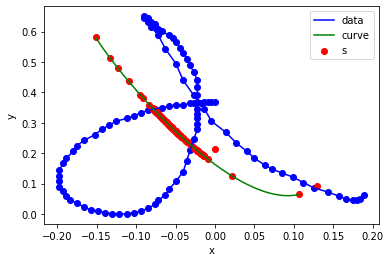

[ 0.          0.6266876   0.67232872  0.73259992  0.98817407  1.7583418
  3.63043631 -0.74223746 -0.26492905 -0.01716141  0.08473733  0.14058313
  0.17603969  0.21193964  0.23537333  0.2520154   0.26570607  0.27902862
  0.28919705  0.29969151  0.30797366  0.31475561  0.3207042   0.32693602
  0.33143639  0.33655825  0.34054323  0.34425869  0.34776973  0.3507347
  0.35435976  0.35712198  0.35986398  0.36313397  0.36580081  0.36805206
  0.37030659  0.37257198  0.3747786   0.3770177   0.37969422  0.38245454
  0.38615225  0.39121427  0.39604455  0.40371936  0.41194756  0.42779342
  0.45475094  0.51340269  0.75001445 -0.31226943  0.23970069  0.30558229
  0.37063444  0.23139992  0.39029544  0.27244244  0.35230221  0.40915407
  0.51532543 -0.00543707  0.26698221  0.31731497  0.33789493  0.35238684
  0.36380026  0.37098017  0.37522081  0.38101801  0.38473711  0.38831499
  0.39038096  0.39378183  0.3953591   0.3973045   0.39922392  0.40072679
  0.40102285  0.40276313  0.40450692  0.40717942  0.4

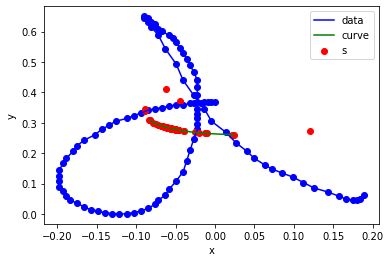

[ 0.00000000e+00  7.69649189e-01  7.93622203e-01  8.16701095e-01
  8.51878770e-01  8.22130635e+00  3.03096612e+00 -1.02261398e-01
  3.04946687e-01  5.25427834e-01  6.24390556e-01  6.85223508e-01
  7.28912853e-01  7.78330072e-01  8.16957649e-01  8.49130256e-01
  8.80396386e-01  9.13107185e-01  9.41974794e-01  9.75159834e-01
  1.00581736e+00  1.03252612e+00  1.05690075e+00  1.08527026e+00
  1.10657632e+00  1.13192947e+00  1.15201415e+00  1.17160157e+00
  1.19073577e+00  1.20641432e+00  1.22679423e+00  1.24259389e+00
  1.25630254e+00  1.27504087e+00  1.28975132e+00  1.30045095e+00
  1.31161352e+00  1.32327580e+00  1.33094309e+00  1.33903585e+00
  1.34321819e+00  1.34772295e+00  1.34829711e+00  1.34483070e+00
  1.33685018e+00  1.32902631e+00  1.31667559e+00  1.30089884e+00
  1.28456921e+00  1.27752191e+00  1.38096396e+00  3.57986526e-01
  8.26245720e-01  8.44597005e-01  8.52784796e-01  7.14732662e-01
  7.82040548e-01  6.47351135e-01  6.28969904e-01  5.61091607e-01
  4.80464316e-01  2.77359

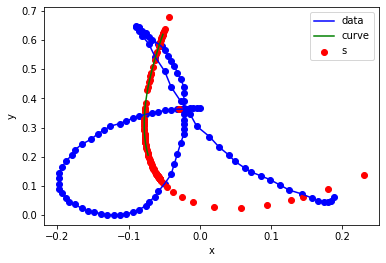

[0.         1.15943269 1.17297049 1.18601164 1.21318671 7.6949776
 5.34677344 0.70027813 0.95542042 1.09299297 1.15958989 1.2053075
 1.24205908 1.29026277 1.33340301 1.37366342 1.41695501 1.46730566
 1.51612849 1.57695411 1.63976943 1.69769474 1.7517211  1.82013529
 1.87249469 1.93652385 1.9858633  2.03495547 2.08377686 2.11958752
 2.16782133 2.20417263 2.22902929 2.26684709 2.29327117 2.30813626
 2.32361842 2.33977003 2.34403228 2.34873327 2.34126213 2.33390826
 2.313886   2.28066295 2.24437459 2.19644467 2.14562196 2.06934556
 1.98072787 1.88901143 1.86421566 1.11764363 1.36856132 1.3457364
 1.31572123 1.21842308 1.22027326 1.11462971 1.06769902 0.9918437
 0.92011009 0.78981434 0.7817679  0.72756915 0.68429933 0.64064077
 0.59684777 0.56772442 0.5534783  0.53981475 0.5260766  0.5125268
 0.49850262 0.48524677 0.48590382 0.47210333 0.45814065 0.45913363
 0.47220949 0.49710409 0.53574255 0.58830485 0.69699155 0.81218898
 0.95817403 1.08932149 1.21612846 1.34402021 1.45544567 1.5849618
 

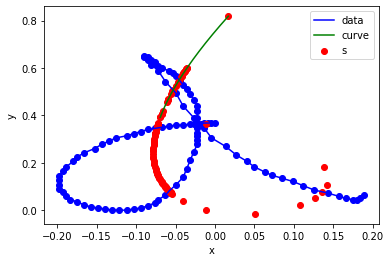

[0.         1.50698859 1.51599455 1.52483527 1.54870864 7.17669432
 7.75549034 1.36803371 1.49457089 1.56903215 1.61352185 1.65000423
 1.68329205 1.73174519 1.77893926 1.82566264 1.87883688 1.94233089
 2.0063826  2.088705   2.17834928 2.26316033 2.34359428 2.45016742
 2.53360692 2.6384366  2.72016012 2.8034522  2.88823064 2.94951278
 3.03432342 3.09880862 3.14003764 3.20611228 3.2509461  3.27338009
 3.29681095 3.32132918 3.32174158 3.32251675 3.29793751 3.27300532
 3.22163459 3.1433444  3.0651496  2.95999636 2.85728596 2.70491343
 2.53472246 2.36000193 2.21974486 1.77539862 1.81906849 1.76485375
 1.70875463 1.6410501  1.59912866 1.51160456 1.44616837 1.36387678
 1.29484364 1.20461474 1.16383436 1.10958351 1.06793344 1.02689082
 0.98649157 0.95872866 0.94326425 0.92452376 0.90947101 0.89458178
 0.8831236  0.86849803 0.86525692 0.85400682 0.84274734 0.83966502
 0.85064053 0.87580732 0.91268198 0.96549458 1.06813112 1.1816353
 1.32451559 1.45772726 1.58804878 1.72154246 1.8360452  1.97120

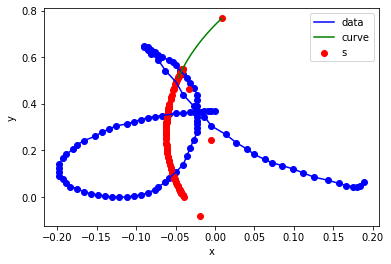

[0.         1.61524241 1.6386341  1.66111583 1.70417482 7.01817859
 7.17405913 1.95989591 1.9066076  1.93627805 1.97957465 2.02416446
 2.06804208 2.12934165 2.18946463 2.24830207 2.31523747 2.39020307
 2.46461639 2.55854593 2.65957054 2.75462442 2.84591528 2.96757931
 3.06551762 3.1925013  3.29685995 3.40744583 3.52522706 3.61722193
 3.750189   3.85814521 3.93451392 4.05939184 4.1507114  4.20047647
 4.25309195 4.30887354 4.31291445 4.31703898 4.26616618 4.21556527
 4.11391189 3.96839139 3.83249742 3.66258626 3.50620728 3.28657614
 3.04874841 2.79992131 2.55757877 2.51418768 2.18349067 2.0778699
 1.97783046 1.91452192 1.81666389 1.71113574 1.60566482 1.48875218
 1.39845574 1.32688273 1.2740517  1.23000878 1.204027   1.1813703
 1.16174276 1.15444565 1.15746158 1.17242354 1.17534193 1.17832858
 1.17031243 1.17364964 1.18446201 1.17702    1.16974161 1.18040801
 1.18764545 1.19229461 1.20592726 1.22022172 1.28201823 1.35436898
 1.49225364 1.62676394 1.77542277 1.95178755 2.09114048 2.275125

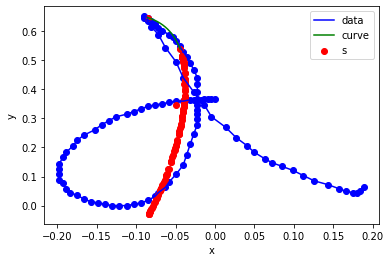

[  0.           1.50279156   1.52090886   1.53949094   1.59121966
   6.55944401   6.62549716   1.53293893   1.76243581   1.88166381
   2.00391269   2.14795358   2.32722372   2.6116249    3.02501939
   3.74076401   6.90608875 -16.37445029  -1.02243562   0.82933736
   1.57351368   2.04887562   2.4515334    2.87842553   3.21402088
   3.6429315    4.01534356   4.43915736   4.97654566   5.49005522
   6.62566849   8.46084532  10.9634509   89.63979701  -8.65324677
  -4.06374806  -1.69621755  -0.24287126  -0.37570369  -0.51637281
  -3.23519529 -13.74551142  14.77504874   7.21460575   5.84540524
   5.0493045    4.63328591   4.25024241   4.02877943   4.24132169
  -0.3251206    3.22551533   1.9929292    1.96771009   1.90087017
   1.83246874   1.73057813   1.57551386   1.39189629   1.1131998
   0.8021586    0.23047157  -0.6278714   -2.65505136  -8.97870679
  41.57834767   9.38238891   6.57744611   5.59757399   4.66246591
   4.3019641    4.02940695   3.95553003   3.75877108   3.64466785
   3.599132

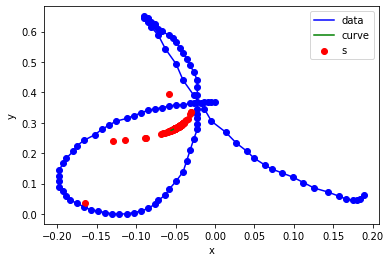

[ 0.00000000e+00 -5.26548303e+00 -2.14446669e+00  6.86405244e-01
  2.27657265e+00  7.48551892e+00  9.87002017e+00  1.36743802e+01
  1.72619870e+01  2.11290652e+01  2.50940797e+01  2.91581688e+01
  3.33258256e+01  4.04305453e+01  4.96202928e+01  6.23028184e+01
  9.08451795e+01 -2.90575025e+01  6.50412048e+02 -3.13500919e+02
 -1.28408159e+02 -7.43022246e+01 -4.78669490e+01 -3.40243519e+01
 -2.62409749e+01 -1.95354536e+01 -1.48691133e+01 -1.13993829e+01
 -8.71091370e+00 -6.32554913e+00 -3.90377144e+00 -2.13802424e+00
 -2.25558256e-01  9.03561475e+01  1.05133486e+00  2.89545474e+00
  4.02515456e+00  4.97510190e+00  5.70624038e+00  6.41567577e+00
  6.78114066e+00  3.35752802e+00  8.54080717e+00  8.82473523e+00
  9.06198140e+00  9.66178467e+00  9.91526238e+00  1.05952665e+01
  1.14349066e+01  1.19629844e+01  1.25387409e+01  1.45765174e+01
  1.83995950e+01  2.28866208e+01  4.70785265e+01 -4.22730516e+01
 -4.45233622e-01  5.62586544e+00  7.70369879e+00  8.91126916e+00
  9.50628237e+00  1.06582

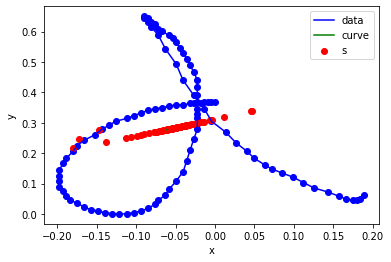

[ 0.00000000e+00  3.88536666e+01  3.96798166e+01  4.03632985e+01
  3.96780425e+01  4.06701043e+01  4.10132944e+01  4.00639348e+01
  3.96045206e+01  3.73580439e+01  3.34765102e+01  2.59995838e+01
  7.98459410e+00 -5.74005054e+02  1.04787410e+02  8.09226104e+01
  7.91160805e+01 -4.33238475e+01  6.49275817e+02 -3.36835806e+02
 -9.61956883e+01 -1.23650754e+02 -2.03313722e+02 -6.46086459e+02
  2.28089042e+03  4.46919404e+02  3.04056056e+02  2.44086606e+02
  2.11199120e+02  1.96142755e+02  1.81578449e+02  1.73484567e+02
  1.70223222e+02  8.68861956e+01  1.71269270e+02  1.69720373e+02
  1.70705072e+02  1.72417741e+02  1.76812278e+02  1.81849023e+02
  1.91644215e+02  2.30220536e+02  2.15343281e+02  2.46875839e+02
  2.81280533e+02  3.78656006e+02  5.86122930e+02 -2.74045044e+03
 -2.36338651e+02 -8.16479414e+01 -2.44508215e+01  5.05780716e+00
  2.29067081e+01  3.08373065e+01  4.04862912e+01  1.29770150e+01
  3.43194172e+01  4.13416217e+01  4.60556676e+01  5.05211648e+01
  5.36325712e+01  5.68641

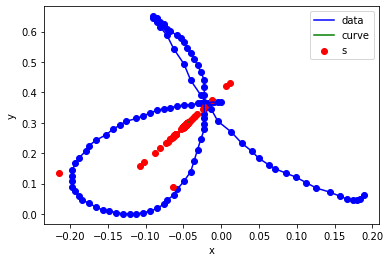

(array([[-4.32159294e-02,  3.01642187e-01,  5.38332993e-01],
        [-9.56161712e-05, -2.25464283e-04, -6.40401661e-05],
        [-1.21862178e-08, -1.37890924e-08, -4.22407382e-08],
        [ 9.31441328e-12,  3.54055402e-11, -8.91218426e-13]]),
 array([ 0.00000000e+00,  3.88536666e+01,  3.96798166e+01,  4.03632985e+01,
         3.96780425e+01,  4.06701043e+01,  4.10132944e+01,  4.00639348e+01,
         3.96045206e+01,  3.73580439e+01,  3.34765102e+01,  2.59995838e+01,
         7.98459410e+00, -5.74005054e+02,  1.04787410e+02,  8.09226104e+01,
         7.91160805e+01, -4.33238475e+01,  6.49275817e+02, -3.36835806e+02,
        -9.61956883e+01, -1.23650754e+02, -2.03313722e+02, -6.46086459e+02,
         2.28089042e+03,  4.46919404e+02,  3.04056056e+02,  2.44086606e+02,
         2.11199120e+02,  1.96142755e+02,  1.81578449e+02,  1.73484567e+02,
         1.70223222e+02,  8.68861956e+01,  1.71269270e+02,  1.69720373e+02,
         1.70705072e+02,  1.72417741e+02,  1.76812278e+02,  1.81849023

In [47]:
def fit_curve_newton_step(data, delta=0.05, precision=0.05, maxiter=10, debug=False):
    print(data.shape)
    D = data[data[:, 2] >= 0]
    s = get_relative_distances(D)
    S = makeSMatrix(s, 4)
    PE = np.linalg.lstsq(S, D, rcond=None)[0]
    
    prev_error = SSE(D, PE, s)
    
    if debug:
        print("Initial fit")
        print(s, prev_error)
        plot2D_curve_with_data(D, PE, s)
    
    if prev_error < precision:
        return PE, s, prev_error
    
    for value in range(maxiter):
        s = newton_step(D, PE, s)
        S = makeSMatrix(s, 4)
        PE = np.linalg.lstsq(S, D, rcond=None)[0]
        
        error = SSE(D, PE, s)

        if debug:
            print(s, error)
            plot2D_curve_with_data(D, PE, s)

        if abs(error - prev_error) < delta:
            break

        prev_error = error
        
    return PE, s, prev_error

fit_curve_newton_step(normalized_timestamps[0], debug=True)

It is clear it is not possible to propely fit curves on this data, so we will need to split the data up. We do this by applying the procedure recursively and splitting up the point we are fitting if the fit is not good enough. This depends on two parameters. The fit is not good enough if the SSE is too large. The fit is also not good enough if the length of the curve is three times as long as the endpoint distances. We split the stroke up by looking at the three consecutive points with the smallest angle.

[2.35619449 3.14159265 3.14159265 2.67794504 2.9996956  3.14159265
 3.06482076 3.06176267 3.02844167 3.06068855 3.04753142 3.04753142
 3.07273616 3.09400955 3.03851105 3.03851105 3.11528294 2.98167953
 2.98167953 3.14159265 2.79856871 2.8753406  3.06482076 2.92292371
 2.9996956  3.14159265 3.14159265 2.8198421  2.35619449 2.35619449
 0.46364761 2.9996956  3.01723766 3.09400955 3.06482076 3.03851105
 3.14159264 3.03851105 3.01723766 3.09400955 2.92292371 3.14159265
 3.14159265 2.67794504 3.14159265 0.78539816 3.14159265 2.67794504
 2.8198421  2.97644398 2.97644398 2.9996956  3.11834103 2.84309372
 3.01723766 2.79856871 2.60117315 2.94419709 2.74680153 2.94419709
 2.35619449 3.14159265 2.35619449]


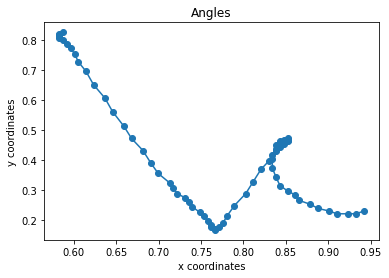

In [37]:
def length_vecs(vec):
    return (vec[:, 0]**2 + vec[:, 1]**2)**(1/2)

def dot_vecs(vec1, vec2):
    return vec1[:, 0]*vec2[:, 0] + vec1[:, 1]*vec2[:, 1]

def calc_angles(stroke):
    D = stroke[stroke[:, 2] >= 0]
    vecs_back = D[1:, :] - D[:-1, :]
    vecs_forward = D[:-1, :] - D[1:, :]

    frac = dot_vecs(vecs_forward[1:], vecs_back[:-1]) / (length_vecs(vecs_forward[1:]) * length_vecs(vecs_back[:-1]))
    
    frac[frac < -1] = -1 # TODO: why is this needed?
    
    return np.arccos(
                frac
            )

print(calc_angles(normalized_timestamps[2]))
plot_stroke(normalized_timestamps[2], "Angles")

Now we only need to split up each stroke.

25 81


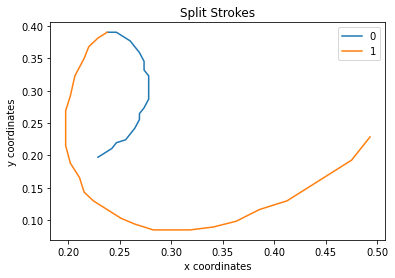

In [38]:
def split_datapoints(stroke):
    angles = calc_angles(stroke)
    indices = np.argsort(angles) + 1
    
    for index in indices:
        if 3 <= index or index <= len(stroke) - 3: # Make sure there are enough datapoints to make the fit.
            return stroke[:index+1], stroke[index:]
    
    return None

a, b = split_datapoints(normalized_timestamps[1])
print(len(a), len(b))
plot_strokes([a, b], "Split Strokes")

In [43]:
def fit_datapoints(datapoints, precision=0.001):
    PE, s, error = fit_curve_newton_step(datapoints)
    stdev = (error/len(datapoints))**(1/2)
    curves = []
    
    curve_diffs = (datapoints[1:, :] - datapoints[:-1, :]) # Smarter way to do this?
    distances = (curve_diffs[:, 0]**2 + curve_diffs[:, 1]**2)**(1/2)
    
    abs_diffs = datapoints[0] - datapoints[-1]
    abs_dist = (abs_diffs[0]**2 + abs_diffs[1]**2)**(1/2)
    
    if stdev > precision or (np.sum(distances) / abs_dist) > 3:
        first_h, second_h = split_datapoints(datapoints)
        curves.extend(fit_datapoints(first_h, precision))
        curves.extend(fit_datapoints(second_h, precision))
    else:
        curves.append([PE, s, stdev, datapoints])
        
    return curves

[0.         0.0044843  0.00896861 0.01345291 0.01979468 0.02876329
 0.03324759 0.04327481 0.05224341 0.06227063 0.07229784 0.08232505
 0.09235226 0.10503579 0.11771932 0.13040285 0.14657124 0.16273963
 0.17890802 0.19896244 0.22138397 0.24143839 0.25992765 0.28407637
 0.30256564 0.32543119 0.34336841 0.36130563 0.37924285 0.39342347
 0.41191273 0.42609335 0.43877688 0.45494527 0.4676288  0.47765601
 0.48768322 0.49771043 0.50667904 0.51564765 0.52567486 0.53570207
 0.5483856  0.564554   0.57873461 0.59878903 0.6172783  0.64563953
 0.67828576 0.71443939 0.75059301 0.78674663 0.81845545 0.83639267
 0.85432989 0.86778281 0.88572003 0.90814155 0.93056308 0.95746891
 0.97989043 1.00716739 1.03003295 1.05289851 1.07138777 1.08987704
 1.1083663  1.12254692 1.13257413 1.14874252 1.15876973 1.16879694
 1.17328125 1.18330846 1.18965022 1.19413453 1.19861883 1.2049606
 1.2094449  1.22362552 1.24211478 1.27047602 1.31620713 1.36733607
 1.42189    1.47301894 1.51983646 1.56117971 1.60128855 1.63960

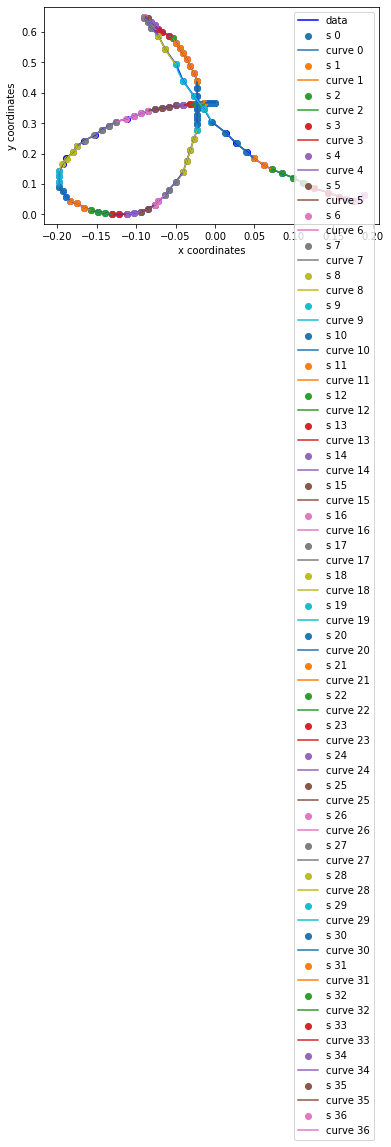

In [44]:
def plot_fitted_curves_with_data(curves, data):
    D = data[data[:, 2] >= 0]    
    plt.scatter(D[:, 0], D[:, 1], color="b")
    plt.plot(D[:, 0], D[:, 1], label="data", color="b")

    for i, (P, s, _, _) in enumerate(curves):
        curve_points = makeSMatrix(s, 4)@P
        curve = makeSMatrix(np.linspace(s[0], s[-1], 1000), 4)@P
        plt.scatter(curve_points[:, 0], curve_points[:, 1], label=f"s {i}")
        plt.plot(curve[:, 0], curve[:, 1], label=f"curve {i}")
        
    plt.xlabel("x coordinates")
    plt.ylabel("y coordinates")
    plt.legend()
    plt.show()

t = 0
fitted_curves = fit_datapoints(normalized_timestamps[t])
plot_fitted_curves_with_data(fitted_curves, normalized_timestamps[t])

In the last step we want to stitch the fitted curves back together, we will look at curves that are next to each other and see if we can fit a new curve containing these two curves.

[0.         0.0044843  0.00896861 0.01345291 0.01979468]
[0.         0.0044843  0.00896861 0.01345291 0.01979468 0.02876329
 0.03324759]
[0.         0.00896861 0.01345291 0.02348013]
[0.         0.00896861 0.01345291 0.02348013 0.03244874]
[0.         0.00896861 0.01899582 0.02902303 0.03905024 0.04907745]
[0.         0.01002721 0.02005442 0.03008163 0.04010884 0.05279237
 0.0654759  0.07815943 0.09432782]
[0.         0.01268353 0.02536706 0.03805059 0.05421898 0.07038737
 0.08655576 0.10661018 0.12903171 0.14908613]
[0.         0.01616839 0.03233678 0.0523912  0.07481273 0.09486715
 0.11335641 0.13750513 0.1559944  0.17885996]
[0.         0.01848926 0.04263798 0.06112725 0.08399281 0.10193002
 0.11986724 0.13780446]
[0.         0.01793722 0.03587444 0.05381166 0.06799228 0.08648154
 0.10066216]
[0.         0.01793722 0.03587444 0.05381166 0.06799228 0.08648154
 0.10066216 0.11334569 0.12951408 0.14219761]
[0.         0.01268353 0.02885192 0.04153545 0.05156266 0.06158987
 0.07161708]


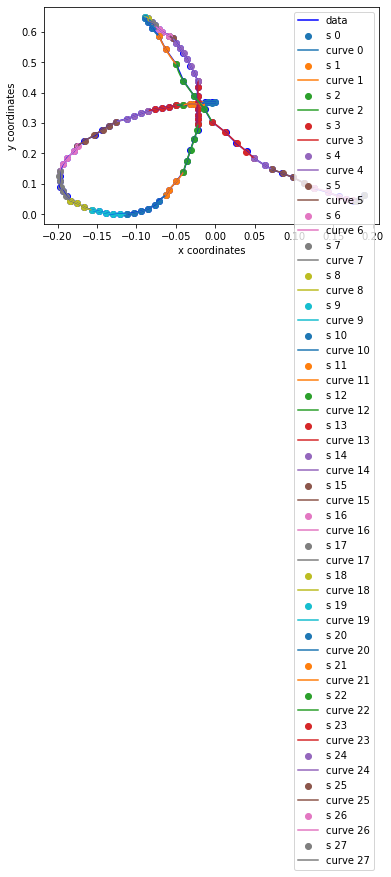

In [45]:
def stitch_curves(fitted_curves, precision=0.001):
    curves = []
    
    for i, _ in enumerate(fitted_curves[:-1]):
        d = np.vstack((fitted_curves[i][3][:-1], fitted_curves[i+1][3]))
        PE, s, error = fit_curve_newton_step(d)
        stdev = (error/len(d))**(1/2)
        
        curve_diffs = (d[1:, :] - d[:-1, :]) # Smarter way to do this?
        distances = (curve_diffs[:, 0]**2 + curve_diffs[:, 1]**2)**(1/2)
    
        abs_diffs = d[0] - d[-1]
        abs_dist = (abs_diffs[0]**2 + abs_diffs[1]**2)**(1/2)
    
        if stdev > precision or (np.sum(distances) / abs_dist) > 3:
            curves.append(fitted_curves[i])
            if i == len(fitted_curves) - 2:
                curves.append(fitted_curves[i+1])
        else:
            if i == len(fitted_curves) - 2:
                curves.append([PE, s, stdev, d])
            else:
                fitted_curves[i+1] = [PE, s, stdev, d]
                
    return curves
        
stiched_curves = stitch_curves(fitted_curves)
print(len(stiched_curves), len(fitted_curves))
plot_fitted_curves_with_data(stiched_curves, normalized_timestamps[t])

Finally we combinde these into on function and parameterize the bezier curve.

In [46]:
def convert_stroke_to_bezier_curves(datapoints):
    fitted_curves = fit_datapoints(datapoints)
    stiched_curves = stitch_curves(fitted_curves)    
    parameters = [parameterize_curve(PE, 1) for (PE, s, stdev, d) in stiched_curves]
    return parameters

convert_stroke_to_bezier_curves(normalized_timestamps[5])

[0.         0.0044843  0.00896861 0.01531037 0.03147877 0.05762653
 0.09620198 0.1509399  0.21938984 0.28406341 0.34636136 0.3986569
 0.43876574 0.46491351 0.48496793 0.49765146 0.50767867 0.51770588
 0.52219018]
[0.         0.0044843  0.00896861 0.01531037 0.03147877 0.05762653
 0.09620198 0.1509399  0.21938984 0.28406341 0.34636136 0.3986569
 0.43876574 0.46491351 0.48496793 0.49765146 0.50767867 0.51770588]
[0.        0.0044843]
[0.         0.0044843  0.01082607 0.02699446 0.05314223 0.09171768
 0.14645559 0.21490554 0.2795791  0.34187706 0.39417259 0.43428143
 0.4604292  0.48048362 0.49316715 0.50319436 0.51322157]
[0.        0.0044843]
[0.         0.00634176 0.02251016 0.04865792 0.08723337 0.14197129
 0.21042123 0.2750948  0.33739275 0.38968829 0.42979713 0.4559449
 0.47599932 0.48868285 0.49871006 0.50873727]
[0.         0.00634176 0.02251016 0.04865792 0.08723337 0.14197129
 0.21042123 0.2750948  0.33739275 0.38968829 0.42979713 0.4559449
 0.47599932]
[0.         0.00634176]
[0

[[1.7930341833716679,
  2.2077022087559137,
  0.8635559594390356,
  0.8364262130176295,
  2.5091158898402397,
  2.3651106799900075,
  0.9670222962823561,
  -1.6726071745785087,
  0.8819723842422702,
  1],
 [1.7930341833716679,
  2.2077022087559137,
  0.8635559594390356,
  0.8364262130176295,
  2.5091158898402397,
  2.3651106799900075,
  0.03219249846956942,
  0.0010433330872871088,
  -0.010858312145779231,
  1],
 [1.7930341833716679,
  2.2077022087559137,
  0.8635559594390356,
  0.8364262130176295,
  2.5091158898402397,
  2.3651106799900075,
  0.0571381603376984,
  -0.03575312381975689,
  0.016713049392514816,
  1],
 [1.7930341833716679,
  2.2077022087559137,
  0.8635559594390356,
  0.8364262130176295,
  2.5091158898402397,
  2.3651106799900075,
  0.05882194584513553,
  -0.08782733824919228,
  0.0795105064695558,
  1],
 [1.7930341833716679,
  2.2077022087559137,
  0.8635559594390356,
  0.8364262130176295,
  2.5091158898402397,
  2.3651106799900075,
  0.027675099965879118,
  -0.01510443

In [41]:
def strokes_to_bezier(strokes):
    points = []

    for stroke in strokes:
        points.extend(convert_stroke_to_bezier_curves(stroke))
        
    return np.array(points)


t = strokes_to_bezier(normalized_timestamps)

print(t.shape)
print(touch_points.shape)

(60, 10)
(209, 5)
